### Estructura.

* Repaso de Métricas
* Prueba con Regresión Lógistica
* Prueba con Random Forest Modelo 1
* Prueba con Random Forest Modelo 2
* Comparación entre modelo 1 y 2
* Prueba con Random Forets Modelo 3 One Hot Encoding
* CV search
* XGBoost
* Prueba con Red Neuronal Recurrente LSTM

### Importación de paquetes necesarios y cargar datos

In [0]:
import json
import os
import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder


Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
root_path = 'gdrive/My Drive/Datos/'

### Prepocesamiento de Datos


In [0]:
#Para Test
#path_to_json = 'C://Users//daoban//OneDrive//Tesis_QEC//SimulacionCircuitos//gen_sampler//p0_1'
path_to_json = root_path
json_files = [pos_json for pos_json in os.listdir(path_to_json) if pos_json.endswith('.json')]

In [0]:
json_files #= json_files[:len(json_files)-1] #xq ya hay una json

['0.json',
 '1.json',
 '2.json',
 '3.json',
 '4.json',
 '5.json',
 '6.json',
 '7.json',
 '8.json',
 '9.json',
 '10.json',
 '11.json',
 '13.json',
 '14.json',
 '15.json',
 '16.json',
 '17.json',
 '12.json',
 '18.json',
 '19.json']

In [0]:
json_text.keys()

NameError: ignored

In [0]:
x_correc = []
x_stab = []
z_correc = []
z_stab = []
final_errors = []
for index, js in enumerate(json_files):
    with open(os.path.join(path_to_json, js)) as json_file:
        json_text = json.load(json_file)
        x_correc.append(json_text['X_corrections'])
        x_stab.append(json_text['X_stab_outcomes'])
        z_correc.append(json_text['Z_corrections'])
        z_stab.append(json_text['Z_stab_outcomes'])
        final_errors.append(json_text['failings_total_NN'])

In [0]:
#relleno los que tienen solo dos mediciones iguales x
for i in range(0,len(x_stab)):
    for j in range(0,len(x_stab[i])):
        if len(x_stab[i][j]) != 3:
           x_stab[i][j].append(x_stab[i][j][0])

In [0]:
#relleno los que tienen solo dos mediciones iguales z
for i in range(0,len(z_stab)):
    for j in range(0,len(z_stab[i])):
        if len(z_stab[i][j]) != 3:
           z_stab[i][j].append(z_stab[i][j][0])

In [0]:
dataz_stab =[]
for i in range(0,len(z_stab)):
    for j in range(0,len(z_stab[i])):
        for k in range(0,len(z_stab[i][j])):
            for l in range(0,len(z_stab[i][j][k])):
                dataz_stab.append(z_stab[i][j][k][l])

In [0]:
datax_stab =[]
for i in range(0,len(x_stab)):
    for j in range(0,len(x_stab[i])):
        for k in range(0,len(x_stab[i][j])):
            for l in range(0,len(x_stab[i][j][k])):
                datax_stab.append(x_stab[i][j][k][l])

In [0]:
numeric = []
for i in range(0,len(final_errors)):
    for j in range(0,len(final_errors[i])):
        numeric.append(final_errors[i][j])
# numeric = np.array(numeric).astype(int)

In [0]:
datax_stab = np.array(datax_stab).reshape((len(json_files)*len(json_text['X_corrections']),12))
dataz_stab = np.array(dataz_stab).reshape((len(json_files)*len(json_text['X_corrections']),12))

indices = []
for index, (vectx, vectz) in enumerate(zip(datax_stab,dataz_stab)):
        if max(vectx)==0 & max(vectz)==0:
            indices.append(index)
delete = indices#[:corte]
datax_stab=np.delete(datax_stab,delete,axis=0)
dataz_stab=np.delete(dataz_stab,delete,axis=0)
numeric = np.delete(numeric,delete,axis=0)
datax3 = np.array(datax_stab).reshape(len(datax_stab)*3,4)
dataz3 = np.array(dataz_stab).reshape(len(datax_stab)*3,4)
numeric3 = []
for i in range(0,len(datax_stab)):
    for j in range(0,3):
        numeric3.append(numeric[i])
numeric3 = np.array(numeric3)
data3_stab = np.concatenate((datax3,dataz3),axis = 1)
data3 = np.concatenate((data3_stab,numeric3.reshape(len(datax_stab)*3,1)),axis=1)

In [0]:
indices = []
for index, (vectx, vectz) in enumerate(zip(datax_stab,dataz_stab)):
        if max(vectx)==0 & max(vectz)==0:
            indices.append(index)

In [0]:
delete = indices[:]   #[:corte]

In [0]:
corte =len(datax_stab)-len(indices)

In [0]:
datax_stab=np.delete(datax_stab,delete,axis=0)
dataz_stab=np.delete(dataz_stab,delete,axis=0)
numeric = np.delete(numeric,delete,axis=0)

In [0]:
datax3 = np.array(datax_stab).reshape(len(datax_stab)*3,4)
dataz3 = np.array(dataz_stab).reshape(len(datax_stab)*3,4)

In [0]:
numeric3 = []
for i in range(0,len(datax_stab)):
    for j in range(0,3):
        numeric3.append(numeric[i])
numeric3 = np.array(numeric3)

In [0]:
data3_stab = np.concatenate((datax3,dataz3),axis = 1)
data3 = np.concatenate((data3_stab,numeric3.reshape(len(datax_stab)*3,1)),axis=1)

In [0]:
data3_stab

array([[0, 1, 1, ..., 1, 0, 0],
       [1, 0, 1, ..., 1, 1, 1],
       [0, 0, 0, ..., 0, 1, 1],
       ...,
       [1, 1, 0, ..., 1, 1, 1],
       [1, 0, 0, ..., 0, 1, 0],
       [1, 1, 1, ..., 0, 0, 0]])

In [0]:
data3

array([[0, 1, 1, ..., 0, 0, 1],
       [1, 0, 1, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       ...,
       [1, 1, 0, ..., 1, 1, 0],
       [1, 0, 0, ..., 1, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])

### Repaso de Métricas
https://developers.google.com/machine-learning/crash-course/classification/precision-and-recall




In [0]:
## Precisión
¿Qué proporción de identificaciones positivas fue correcta? <br>

$$ \frac{TP}{TP+FP}$$

## Exhautividad o Recall (recuperación)
¿Qué proporción de positivos reales se identificó correctamente?

$$ \frac{TP}{TP+FN}$$

### Regresion Logistica


In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

In [0]:
model = LogisticRegression(solver='liblinear', random_state=0)

In [0]:
len(data3_stab)

2918553

In [0]:
x_training_log = data3_stab[0:round(len(data3_stab)*0.8),]

In [0]:
y_training_log = numeric3[0:round(len(data3_stab)*0.8),]

In [0]:
x_test_log = data3_stab[round(len(data3_stab)*0.8):len(data3_stab),]

In [0]:
y_test_log = numeric3[round(len(data3_stab)*0.8):len(data3_stab),]

In [0]:
model.fit(x_training_log,y_training_log)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
y_predicho = model.predict(x_test_log)

In [0]:
model.score(x_test_log,y_test_log)

0.5451139348067794

In [0]:
len(data3_stab[0])

8

In [0]:
confusion_matrix(y_test_log,y_predicho)

array([[314594,   3785],
       [261737,   3595]])

In [0]:
model


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

### Función que permite graficar ROC Value

evaluate_model(predictions, probs, train_predictions, train_probs,test_labels ,train_labels) 

In [0]:
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model(predictions, probs, train_predictions, train_probs,test_labels ,train_labels):
    """Compare machine learning model to baseline performance.
    Computes statistics and shows ROC curve."""
    
    baseline = {}
    
    baseline['recall'] = recall_score(test_labels, [1 for _ in range(len(test_labels))])
    baseline['precision'] = precision_score(test_labels, [1 for _ in range(len(test_labels))])
    baseline['roc'] = 0.5
    
    results = {}
    
    results['recall'] = recall_score(test_labels, predictions)
    results['precision'] = precision_score(test_labels, predictions)
    results['roc'] = roc_auc_score(test_labels, probs)
    
    train_results = {}
    train_results['recall'] = recall_score(train_labels, train_predictions)
    train_results['precision'] = precision_score(train_labels, train_predictions)
    train_results['roc'] = roc_auc_score(train_labels, train_probs)
    
    for metric in ['recall', 'precision', 'roc']:
        print(f'{metric.capitalize()} Baseline: {round(baseline[metric], 2)} Test: {round(results[metric], 2)} Train: {round(train_results[metric], 2)}')
    
    # Calculate false positive rates and true positive rates
    base_fpr, base_tpr, _ = roc_curve(test_labels, [1 for _ in range(len(test_labels))])
    model_fpr, model_tpr, _ = roc_curve(test_labels, probs)

    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16
    
    # Plot both curves
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'r', label = 'model')
    plt.legend();
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC Curves');

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Modelo_1 Random Forest Algoritmo Sin Encoding


In [0]:


# Create the model with 100 trees
model = RandomForestClassifier(n_estimators=100, 
                               bootstrap = True,
                               max_features = 'sqrt')

#RF_X_train Set X para entrenamiento en Random Forest
RF_X_train, RF_X_test, RF_y_train, RF_y_test = train_test_split(data3_stab, numeric3, test_size=0.20, random_state=0)

# Fit on training data
model.fit(RF_X_train, RF_y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [0]:
RF_X_train

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 1, 1, ..., 1, 0, 1],
       [0, 0, 1, ..., 1, 0, 1],
       ...,
       [1, 1, 0, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 1]])

In [0]:
RF_y_train

array([False,  True,  True, ..., False, False,  True])

In [0]:
#Acurracy
model.score(RF_X_test,RF_y_test)

0.5463902513401323

In [0]:
# Actual class predictions
rf_predictions = model.predict(RF_X_test)
train_predictions = model.predict(RF_X_train)
# Probabilities for each class
rf_probs = model.predict_proba(RF_X_test)[:,1]

In [0]:
from sklearn.metrics import roc_auc_score
# Calculate roc auc
roc_value = roc_auc_score(RF_y_test, rf_probs)

In [0]:
# Make probability predictions
train_probs = model.predict_proba(RF_X_train)[:, 1]
probs = model.predict_proba(RF_X_test)[:, 1]

In [0]:
print(f'Train ROC AUC Score: {roc_auc_score(RF_y_train, train_probs)}')
print(f'Test ROC AUC  Score: {roc_auc_score(RF_y_test, probs)}')

Train ROC AUC Score: 0.5270817737523774
Test ROC AUC  Score: 0.5262466002490023


Métrica para RandomForest curva ROC (curva de característica operativa del recepto) https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc

roc_value

In [0]:
roc_value

0.5262466002490023

The final testing ROC AUC for the random forest was 0.5262

The perfect value for ROC AUC value is 1.0


In [0]:
from sklearn.metrics import roc_curve

FPR, TPR, thresholds = roc_curve(RF_y_test, rf_probs, pos_label=None, sample_weight=None, drop_intermediate=True)

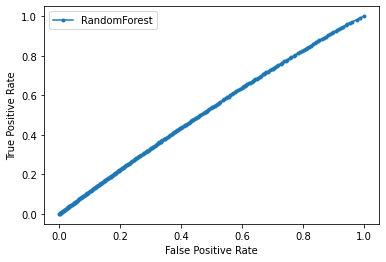

In [0]:
from matplotlib import pyplot

# plot the roc curve for the model
pyplot.plot(FPR, TPR, marker='.', label='RandomForest')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

Recall Baseline: 1.0 Test: 0.01 Train: 0.01
Precision Baseline: 0.45 Test: 0.48 Train: 0.5
Roc Baseline: 0.5 Test: 0.53 Train: 0.53


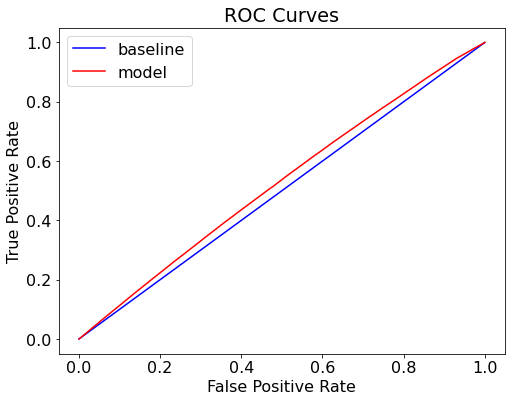

In [0]:
evaluate_model(rf_predictions, rf_probs, train_predictions, train_probs,RF_y_test ,RF_y_train)

In [0]:
#ConfusionMatrix

confusion_matrix(RF_y_test,rf_predictions)

array([[317461,   1593],
       [263184,   1473]])

In [0]:
print(classification_report(RF_y_test, rf_predictions))

              precision    recall  f1-score   support

       False       0.55      1.00      0.71    319054
        True       0.48      0.01      0.01    264657

    accuracy                           0.55    583711
   macro avg       0.51      0.50      0.36    583711
weighted avg       0.52      0.55      0.39    583711



### Modelo_2 Random Forest Algoritmo Con Label Encoding

In [0]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

In [0]:
numeric3

array([ True,  True,  True, ..., False, False, False])

In [0]:
# creating instance of labelencoder
labelencoder = LabelEncoder()

#Tranform the values of numeric3 list in array of 0s and 1s
Y = labelencoder.fit_transform(numeric3)

In [0]:
Y

array([1, 1, 1, ..., 0, 0, 0])

In [0]:
# Create input for Random Forest Model 2
X_RF = data3_stab
Y_RF_encode = Y

In [0]:
#Split data
RF_X_train_2, RF_X_test_2, RF_y_train_2, RF_y_test_2 = train_test_split(X_RF, Y_RF_encode, test_size=0.20, random_state=0)

In [0]:
RF_y_train_2

array([0, 1, 1, ..., 0, 0, 1])

In [0]:
model_2 = RandomForestClassifier(n_estimators=100, 
                               bootstrap = True,
                               max_features = 'sqrt')

In [0]:
model_2.fit(RF_X_train_2, RF_y_train_2)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [0]:
#Acurracy model_2
model_2.score(RF_X_test_2,RF_y_test_2)

0.5465067473458612

Acc model_1 = 0.5464 <br>
Acc_model_2 = 0.5465 <br>


In [0]:
# Actual class predictions
rf_predictions_2 = model_2.predict(RF_X_test_2)
train_predictions_2 = model_2.predict(RF_X_train_2)
# Probabilities for each class
rf_probs_2 = model_2.predict_proba(RF_X_test_2)[:,1]

In [0]:
a =  model_2.predict_proba(RF_X_test_2)

In [0]:
a.shape

(583711, 2)

In [0]:
len(rf_probs_2)

583711

In [0]:
from sklearn.metrics import roc_auc_score
# Calculate roc auc
roc_value_2 = roc_auc_score(RF_y_test_2, rf_probs_2)

In [0]:
# Make probability predictions
train_probs_2 = model_2.predict_proba(RF_X_train_2)[:, 1]
probs_2 = model_2.predict_proba(RF_X_test_2)[:, 1]

In [0]:
print(f'Train ROC AUC Score: {roc_auc_score(RF_y_train_2, train_probs_2)}')
print(f'Test ROC AUC  Score: {roc_auc_score(RF_y_test_2, probs_2)}')

Train ROC AUC Score: 0.5270826535905123
Test ROC AUC  Score: 0.5262548006401597


Métrica para RandomForest curva ROC (curva de característica operativa del recepto) https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc

In [0]:
roc_value_2

0.5262548006401597

The final testing ROC AUC for the random forest with label encoding was 0.5262

The perfect value for ROC AUC value is 1.0


In [0]:
from sklearn.metrics import roc_curve

FPR, TPR, thresholds = roc_curve(RF_y_test_2, rf_probs_2, pos_label=None, sample_weight=None, drop_intermediate=True)

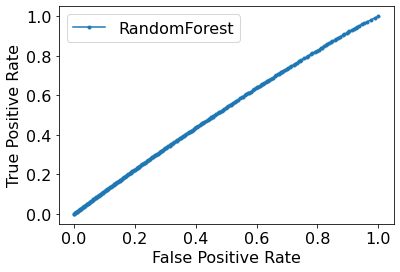

In [0]:
from matplotlib import pyplot

# plot the roc curve for the model
pyplot.plot(FPR, TPR, marker='.', label='RandomForest')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

Recall Baseline: 1.0 Test: 0.0 Train: 0.0
Precision Baseline: 0.45 Test: 0.49 Train: 0.51
Roc Baseline: 0.5 Test: 0.53 Train: 0.53


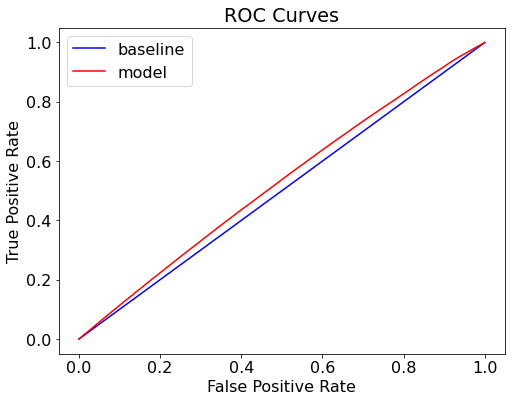

In [0]:
evaluate_model(rf_predictions_2, rf_probs_2, train_predictions_2, train_probs_2,RF_y_test_2 ,RF_y_train_2)

In [0]:
#ConfusionMatrix

confusion_matrix(RF_y_test_2,rf_predictions_2)

array([[318007,   1047],
       [263662,    995]])

In [0]:
print(classification_report(RF_y_test_2, rf_predictions_2))

              precision    recall  f1-score   support

           0       0.55      1.00      0.71    319054
           1       0.49      0.00      0.01    264657

    accuracy                           0.55    583711
   macro avg       0.52      0.50      0.36    583711
weighted avg       0.52      0.55      0.39    583711



### Comparación entre Modelo 1 y modelo 2

| Modelo |             | Positive(1) | Negative(0) |
|:------:|:-----------:|:-----------:|:-----------:|
|    1   | Positive(1) |    317461   |     1593    |
|    1   | Negative(1) |    263184   |     1473    |
|    2   | Positive(1) |    318007   |     1047    |
|    2   | Negative(2) |    263662   |     995     |




El modelo con label encoding mejora con los True Positive, pero empeora con los True Negative

### Modelo_3 Random Forest One Hot encoding

In [0]:
X_3 = data3_stab
Y_3 = numeric3

In [0]:
len(Y_3)

2918553

In [0]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder


# integer encode
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(Y_3)
print('Interger enconde:',integer_encoded)
# binary encode
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = np.array(onehot_encoder.fit_transform(integer_encoded))
print(onehot_encoded)

#onehot_encoded es Y

Interger enconde: [1 1 1 ... 0 0 0]
[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [0]:
onehot_encoded.shape

(2918553, 2)

In [0]:
#Split data
RF_X_train_3, RF_X_test_3, RF_y_train_3, RF_y_test_3 = train_test_split(X_3, onehot_encoded, test_size=0.20, random_state=0)

In [0]:
RF_X_train_3

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 1, 1, ..., 1, 0, 1],
       [0, 0, 1, ..., 1, 0, 1],
       ...,
       [1, 1, 0, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 1]])

IndexError: ignored

In [0]:
RF_y_test_3

array([[1., 0.],
       [0., 1.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

In [0]:
model_3 = RandomForestClassifier(n_estimators=100, 
                               bootstrap = True,
                               max_features = 'sqrt')

In [0]:
model_3.fit(RF_X_train_3, RF_y_train_3)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [0]:
# Actual class predictions
rf_predictions_3 = model_3.predict(RF_X_test_3)


In [0]:
rf_predictions_3

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

In [0]:
model_3.score(RF_X_test_3,RF_y_test_3)

0.5465067473458612

Acc_model_1 = 0.54639 <br> 
Acc_model_2 = 0.54651 <br> 
Acc_model_3 = 0.54651 <br> 


In [0]:
# Probabilities for each class
rf_probs_3 = model_3.predict_proba(RF_X_test_3)

In [0]:
rf_probs_3

[array([[0.44245509, 0.55754491],
        [0.43719174, 0.56280826],
        [0.44639471, 0.55360529],
        ...,
        [0.43719174, 0.56280826],
        [0.47464887, 0.52535113],
        [0.43803805, 0.56196195]]), array([[0.55754491, 0.44245509],
        [0.56280826, 0.43719174],
        [0.55360529, 0.44639471],
        ...,
        [0.56280826, 0.43719174],
        [0.52535113, 0.47464887],
        [0.56196195, 0.43803805]])]

In [0]:
print(classification_report(RF_y_test_3, rf_predictions_3))

              precision    recall  f1-score   support

           0       0.55      1.00      0.71    319054
           1       0.49      0.00      0.01    264657

   micro avg       0.55      0.55      0.55    583711
   macro avg       0.52      0.50      0.36    583711
weighted avg       0.52      0.55      0.39    583711
 samples avg       0.55      0.55      0.55    583711



### Optimización Random Forest con CV Search

In [0]:
from sklearn.model_selection import RandomizedSearchCV

# Hyperparameter grid
param_grid = {
    'n_estimators': np.linspace(10, 200).astype(int),
    'max_depth': [None] + list(np.linspace(3, 20).astype(int)),
    'max_features': ['auto', 'sqrt', None] + list(np.arange(0.5, 1, 0.1)),
    'max_leaf_nodes': [None] + list(np.linspace(10, 50, 500).astype(int)),
    'min_samples_split': [2, 5, 10],
    'bootstrap': [True, False]
}

# Estimator for use in random search
estimator = RandomForestClassifier()

In [0]:
# Create the random search model
rf = RandomizedSearchCV(estimator, param_grid, n_jobs = -1, 
                        scoring = 'roc_auc', cv = 3, 
                        n_iter = 10, verbose = 1)

In [0]:
# Fit 
rf.fit(RF_X_train, RF_y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 40.4min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [0]:
rf.best_params_

{'bootstrap': True,
 'max_depth': 14,
 'max_features': 'sqrt',
 'max_leaf_nodes': 30,
 'min_samples_split': 2,
 'n_estimators': 196}

In [0]:
#Modelo Optimiazado

best_model = rf.best_estimator_

In [0]:
train_rf_predictions = best_model.predict(RF_X_train)
train_rf_probs = best_model.predict_proba(RF_X_train)[:, 1]

rf_predictions = best_model.predict(RF_X_test)
rf_probs = best_model.predict_proba(RF_X_test)[:, 1]

In [0]:
%matplotlib inline

In [0]:
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model(predictions, probs, train_predictions, train_probs,test_labels = RF_y_test ,train_labels= RF_y_train):
    """Compare machine learning model to baseline performance.
    Computes statistics and shows ROC curve."""
    
    baseline = {}
    
    baseline['recall'] = recall_score(test_labels, [1 for _ in range(len(test_labels))])
    baseline['precision'] = precision_score(test_labels, [1 for _ in range(len(test_labels))])
    baseline['roc'] = 0.5
    
    results = {}
    
    results['recall'] = recall_score(test_labels, predictions)
    results['precision'] = precision_score(test_labels, predictions)
    results['roc'] = roc_auc_score(test_labels, probs)
    
    train_results = {}
    train_results['recall'] = recall_score(train_labels, train_predictions)
    train_results['precision'] = precision_score(train_labels, train_predictions)
    train_results['roc'] = roc_auc_score(train_labels, train_probs)
    
    for metric in ['recall', 'precision', 'roc']:
        print(f'{metric.capitalize()} Baseline: {round(baseline[metric], 2)} Test: {round(results[metric], 2)} Train: {round(train_results[metric], 2)}')
    
    # Calculate false positive rates and true positive rates
    base_fpr, base_tpr, _ = roc_curve(test_labels, [1 for _ in range(len(test_labels))])
    model_fpr, model_tpr, _ = roc_curve(test_labels, probs)

    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16
    
    # Plot both curves
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'r', label = 'model')
    plt.legend();
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC Curves');

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Recall Baseline: 1.0 Test: 0.0 Train: 0.0
Precision Baseline: 0.45 Test: 0.0 Train: 0.0
Roc Baseline: 0.5 Test: 0.53 Train: 0.53


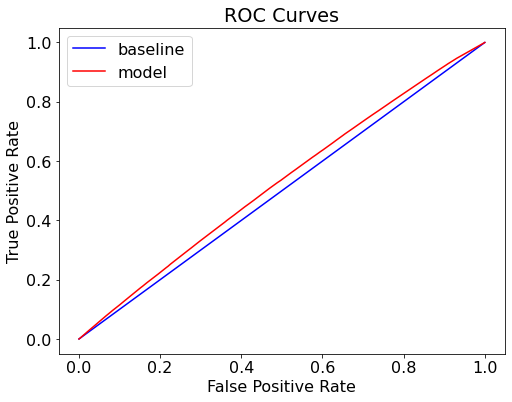

In [0]:
evaluate_model(rf_predictions, rf_probs, train_rf_predictions, train_rf_probs)

In [0]:
print(f'Train ROC AUC Score: {roc_auc_score(RF_y_train, train_rf_probs)}')
print(f'Test ROC AUC  Score: {roc_auc_score(RF_y_test, rf_probs)}')

Train ROC AUC Score: 0.5264573648614457
Test ROC AUC  Score: 0.5269045133421166


### Modelo XGBoost

Referencias de implementación

*https://www.datacamp.com/community/tutorials/xgboost-in-python
*https://towardsdatascience.com/a-beginners-guide-to-xgboost-87f5d4c30ed7
*https://machinelearningmastery.com/develop-first-xgboost-model-python-scikit-learn/


In [0]:
#Instalando Xgboots
!pip install xgboost

In [0]:
# Importanto paquetes

import xgboost as xgb
from sklearn.metrics import log_loss
import pandas as pd
import numpy as np

In [0]:
#Features ands labels
X_Boost = data3_stab
Y_Boost = numeric3

In [0]:
#Apliquemos one hot encoding a las labels
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

# integer encode
label_encoder_2 = LabelEncoder()
integer_encoded_2 = label_encoder_2.fit_transform(Y_Boost)
print('Y_Boost',Y_Boost)
print('Interger enconde:',integer_encoded_2)
# binary encode
onehot_encoder_2 = OneHotEncoder(sparse=False)
integer_encoded_2 = integer_encoded_2.reshape(len(integer_encoded_2), 1)
onehot_encoded_2 = np.array(onehot_encoder_2.fit_transform(integer_encoded_2))
print(onehot_encoded_2)

#onehot_encoded es Y


Y_Boost [ True  True  True ... False False False]
Interger enconde: [1 1 1 ... 0 0 0]
[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [0]:
#Split data
Boost_X_train, Boost_X_test, Boost_y_train, Boost_y_test = train_test_split(X_Boost, integer_encoded_2 , test_size=0.20, random_state=0)

Now you will convert the dataset into an optimized data structure called Dmatrix that XGBoost supports and gives it acclaimed performance and efficiency gains. You will use this later in the tutorial.

In [0]:
data_dmatrix = xgb.DMatrix(data=X_Boost,label=integer_encoded_2)

The next step is to instantiate an XGBoost regressor object by calling the XGBRegressor() class from the XGBoost library with the hyper-parameters passed as arguments. For classification problems, you would have used the XGBClassifier() class.

objective: determines the loss function to be used like reg:linear for regression problems, reg:logistic for classification problems with only decision, binary:logistic for classification problems with probability.

In [0]:
#Haremos la prueba con binary:logistic

In [0]:
xg_reg = xgb.XGBRegressor(objective ='reg:logistic', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)

In [0]:
xg_reg.fit(Boost_X_train,Boost_y_train)

preds = xg_reg.predict(Boost_X_test)

In [0]:
preds

array([0.46668985, 0.46832535, 0.46598697, ..., 0.46832535, 0.47631407,
       0.46734506], dtype=float32)

In [0]:
#By default the predictions made by XGBoost are probabilities. Because this is a binary classification problem, 
#each prediction is the probability of the input pattern belonging to the first class.
#We can easily convert them to binary class values by rounding them to 0 or 1.

predictions = [round(value) for value in preds]

In [0]:
Boost_y_test

array([[0],
       [1],
       [0],
       ...,
       [0],
       [0],
       [0]])

In [0]:
loss = log_loss(Boost_y_test, preds)
print("RMSE: %f" % (loss))

RMSE: 0.689024


In [0]:
accuracy = accuracy_score(Boost_y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 54.66%


### Red Recurrente

In [0]:
np.savetxt('training_p01.csv',data3,delimiter=",")

In [0]:
def separar_secuencia(secuencia,pasos_tiempo):
    x, y = list(), list()
    for i in range(len(secuencia)):
        final_ix = i +pasos_tiempo
        if final_ix > len(secuencia)-1:
            break
        #juntamos la serie y resultado del siguiente paso
        seq_x, seq_y = secuencia[i:final_ix,:-1], secuencia[final_ix-1,-1]
        x.append(seq_x)
        y.append(seq_y)
    return np.array(x), np.array(y)

In [0]:
pasos_tiempo3 = 3
x3_0, y3_0 = separar_secuencia(data3,pasos_tiempo3)

In [0]:
x3 = []
y3 = []
for index in range(0,len(x3_0)):
    if index==0:
        x3.append(x3_0[index])
    elif index%3 == 0:
        x3.append(x3_0[index])
for index in range(0,len(y3_0)):
    if index==0:
        y3.append(y3_0[index])
    elif index%3 == 0:
        y3.append(y3_0[index])
x3 = np.array(x3)
y3 = np.array(y3)

In [0]:
indices = np.arange(x3.shape[0])

In [0]:
np.random.shuffle(indices)

In [0]:
x3 = x3[indices]
y3 = y3[indices]

In [0]:
x3

array([[[0, 0, 0, ..., 1, 0, 0],
        [1, 0, 0, ..., 1, 1, 0],
        [0, 1, 0, ..., 1, 0, 0]],

       [[0, 1, 0, ..., 0, 0, 0],
        [0, 1, 1, ..., 0, 1, 1],
        [1, 1, 0, ..., 0, 1, 0]],

       [[1, 1, 0, ..., 1, 1, 1],
        [1, 0, 0, ..., 0, 1, 0],
        [0, 1, 0, ..., 1, 1, 0]],

       ...,

       [[0, 1, 0, ..., 0, 0, 0],
        [0, 1, 1, ..., 0, 0, 1],
        [1, 1, 1, ..., 0, 1, 1]],

       [[0, 1, 0, ..., 0, 0, 0],
        [1, 0, 1, ..., 1, 0, 1],
        [0, 1, 0, ..., 1, 1, 1]],

       [[0, 0, 0, ..., 1, 1, 0],
        [0, 1, 0, ..., 1, 0, 1],
        [1, 1, 0, ..., 0, 0, 1]]])

In [0]:
x_train3 = x3[0:round(len(x3)*0.8)]
y_train3 = y3[0:round(len(y3)*0.8)]
x_test3 = x3[round(len(x3)*0.8):len(x3)]
y_test3 = y3[round(len(y3)*0.8):len(y3)]

In [0]:
y_train3= keras.utils.to_categorical(y_train3,num_classes=2)
y_test3 = keras.utils.to_categorical(y_test3,num_classes=2)

In [0]:
y_train3.shape

(778280, 2)

In [0]:
(2334842, 2)

In [0]:
n_stab3 = 8

In [0]:
model3 = Sequential()
model3.add(LSTM(128,
               activation = 'relu',
               return_sequences = True,
               input_shape = (pasos_tiempo3,n_stab3)))
model3.add(LSTM(64, activation='relu'))
model3.add(Dropout(0.5))
model3.add(Dense(64,activation = 'relu'))
model3.add(Dropout(0.3))
model3.add(Dense(32,activation = 'relu'))
model3.add(Dropout(0.3))
model3.add(Dense(16,activation = 'relu'))
model3.add(Dense(2, activation='softmax'))

In [0]:
model3.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [0]:
history = model3.fit(x_train3, y_train3,batch_size=300, epochs=20,validation_data=(x_test3 ,y_test3 ),verbose=1)

Train on 778280 samples, validate on 194570 samples
Epoch 1/20
778280/778280 [==============================] - 37s 48us/step - loss: 0.6857 - accuracy: 0.5456 - val_loss: 0.6859 - val_accuracy: 0.5436
Epoch 2/20
778280/778280 [==============================] - 36s 47us/step - loss: 0.6855 - accuracy: 0.5458 - val_loss: 0.6863 - val_accuracy: 0.5435
Epoch 3/20
778280/778280 [==============================] - 36s 46us/step - loss: 0.6853 - accuracy: 0.5460 - val_loss: 0.6862 - val_accuracy: 0.5435
Epoch 4/20
778280/778280 [==============================] - 36s 47us/step - loss: 0.6852 - accuracy: 0.5460 - val_loss: 0.6860 - val_accuracy: 0.5436
Epoch 5/20
778280/778280 [==============================] - 36s 47us/step - loss: 0.6851 - accuracy: 0.5462 - val_loss: 0.6860 - val_accuracy: 0.5437
Epoch 6/20
778280/778280 [==============================] - 36s 46us/step - loss: 0.6850 - accuracy: 0.5460 - val_loss: 0.6862 - val_accuracy: 0.5435
Epoch 7/20
778280/778280 [======================

In [0]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

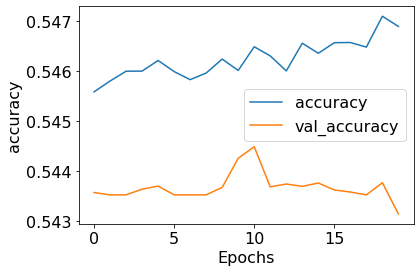

In [0]:
plot_graphs(history, 'accuracy')

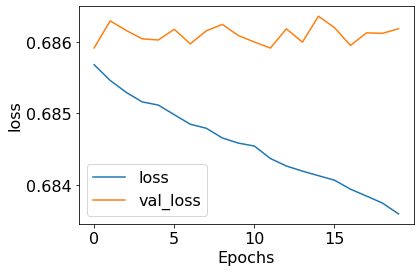

In [0]:
plot_graphs(history, 'loss')

In [0]:
model3.save('modelo.h5')

In [0]:
score3 = model3.evaluate(x_test3, y_test3, batch_size=256)
score3

324000/324000 [==============================] - 9s 29us/step


[0.5007690983171816, 0.7523765431981028]

In [0]:
from keras.models import load_model

In [0]:
model3 = load_model('modelo.h5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


In [0]:
texto = """x_correc_02e = []
x_stab_02e = []
z_correc_02e = []
z_stab_02e = []
final_errors_02e = []
with open(path_to_json+'0_2.json') as json_file:
    json_text = json.load(json_file)
x_correc_02e.append(json_text['X_corrections'])
x_stab_02e.append(json_text['X_stab_outcomes'])
z_correc_02e.append(json_text['Z_corrections'])
z_stab_02e.append(json_text['Z_stab_outcomes'])
final_errors_02e.append(json_text['failings_total_NN'])
for i in range(0,len(x_stab_02e)):
    for j in range(0,len(x_stab_02e[i])):
        if len(x_stab_02e[i][j]) != 3:
           x_stab_02e[i][j].append(x_stab_02e[i][j][0])
#relleno los que tienen solo dos mediciones iguales z
for i in range(0,len(z_stab_02e)):
    for j in range(0,len(z_stab_02e[i])):
        if len(z_stab_02e[i][j]) != 3:
           z_stab_02e[i][j].append(z_stab_02e[i][j][0])
dataz_stab_02e =[]
for i in range(0,len(z_stab_02e)):
    for j in range(0,len(z_stab_02e[i])):
        for k in range(0,len(z_stab_02e[i][j])):
            for l in range(0,len(z_stab_02e[i][j][k])):
                dataz_stab_02e.append(z_stab_02e[i][j][k][l])
datax_stab_02e =[]
for i in range(0,len(x_stab_02e)):
    for j in range(0,len(x_stab_02e[i])):
        for k in range(0,len(x_stab_02e[i][j])):
            for l in range(0,len(x_stab_02e[i][j][k])):
                datax_stab_02e.append(x_stab_02e[i][j][k][l])
datax_stab_02e = np.array(datax_stab_02e).reshape((30000,12))
dataz_stab_02e = np.array(dataz_stab_02e).reshape((30000,12))
numeric_02e = []
for i in range(0,len(final_errors_02e[0])):
    for j in range(0,3):
        numeric_02e.append(final_errors_02e[0][i])
numeric_02e = np.array(numeric_02e).astype(int)
indices = []
for index, (vectx, vectz) in enumerate(zip(datax_stab_02e,dataz_stab_02e)):
        if max(vectx)==0 & max(vectz)==0:
            indices.append(index)
delete_02e = indices#[:corte]
datax_stab_02e=np.delete(datax_stab_02e,delete_02e,axis=0)
dataz_stab_02e=np.delete(dataz_stab_02e,delete_02e,axis=0)
numeric_02e = np.delete(numeric_02e,delete_02e,axis=0)
datax3 = np.array(datax_stab_02e).reshape(len(datax_stab_02e)*3,4)
dataz3 = np.array(dataz_stab_02e).reshape(len(datax_stab_02e)*3,4)
numeric3 = []
for i in range(0,len(datax_stab_02e)):
    for j in range(0,3):
        numeric3.append(numeric_02e[i])
numeric3 = np.array(numeric3)
data3_stab = np.concatenate((datax3,dataz3),axis = 1)
data3 = np.concatenate((data3_stab,numeric3.reshape(len(datax_stab_02e)*3,1)),axis=1)
pasos_tiempo3 = 3
x3_0, y3_0 = separar_secuencia(data3,pasos_tiempo3)
x3 = []
y3 = []
for index in range(0,len(x3_0)):
    if index==0:
        x3.append(x3_0[index])
    elif index%3 == 0:
        x3.append(x3_0[index])
for index in range(0,len(y3_0)):
    if index==0:
        y3.append(y3_0[index])
    elif index%3 == 0:
        y3.append(y3_0[index])
x3 = np.array(x3)
x3=x3[round(len(x3)*0.8):len(x3)]
y3 = np.array(y3)
y3=y3[round(len(y3)*0.8):len(y3)]
y3= keras.utils.to_categorical(y3,num_classes=2)
acc_02e = model3.evaluate(x3, y3, batch_size=256)[1]
delete_02e = len(delete_02e)
acc_02e"""

In [0]:
files = []
for file in json_files:
    files.append(file.replace('.json',''))

In [0]:
numbers = []
for n in files:
    numbers.append(n.replace('_',''))

In [0]:
for i,j in zip(files,numbers):
    print(i,j)
    t1 = texto.replace('0_2',i)
    string = j+'e'
    t2 = t1.replace('02e',string)
    exec(t2)

0_1 01
2055/2055 [==============================] - 1s 304us/step
0_2 02
3317/3317 [==============================] - 0s 28us/step
0_3 03
4144/4144 [==============================] - 0s 26us/step
0_4 04
4674/4674 [==============================] - 0s 27us/step
0_5 05
5065/5065 [==============================] - 0s 28us/step
0_6 06
5296/5296 [==============================] - 0s 24us/step
0_7 07
5482/5482 [==============================] - 0s 26us/step
0_8 08
5579/5579 [==============================] - 0s 31us/step
0_9 09
5681/5681 [==============================] - 0s 27us/step
1_0 10
2003/2003 [==============================] - 0s 31us/step
1_1 11
3319/3319 [==============================] - 0s 33us/step
1_2 12
4171/4171 [==============================] - 0s 26us/step
1_3 13
4720/4720 [==============================] - 0s 26us/step
1_4 14
5081/5081 [==============================] - 0s 28us/step
1_5 15
5317/5317 [==============================] - 0s 26us/step
1_6 16
5476/5476 [======

In [0]:
acc = np.array([acc_01e,acc_02e,acc_03e,acc_04e,acc_05e,acc_06e,acc_07e,acc_08e,acc_09e,acc_10e,acc_11e,acc_12e,acc_13e,acc_14e,acc_15e,acc_16e,acc_17e,acc_18e,acc_20e,acc_21e,acc_22e,acc_23e,acc_24e,acc_25e,acc_26e,acc_27e,acc_30e,acc_31e,acc_32e,acc_33e,acc_34e,acc_35e,acc_36e,acc_40e,acc_41e,acc_42e,acc_43e,acc_44e,acc_45e,acc_50e,acc_51e,acc_52e,acc_53e,acc_54e,acc_60e,acc_61e,acc_62e,acc_63e,acc_70e,acc_71e,acc_72e,acc_80e,acc_81e,acc_90e])

In [0]:
delete = np.array([delete_01e,delete_02e,delete_03e,delete_04e,delete_05e,delete_06e,delete_07e,delete_08e,delete_09e,delete_10e,delete_11e,delete_12e,delete_13e,delete_14e,delete_15e,delete_16e,delete_17e,delete_18e,delete_20e,delete_21e,delete_22e,delete_23e,delete_24e,delete_25e,delete_26e,delete_27e,delete_30e,delete_31e,delete_32e,delete_33e,delete_34e,delete_35e,delete_36e,delete_40e,delete_41e,delete_42e,delete_43e,delete_44e,delete_45e,delete_50e,delete_51e,delete_52e,delete_53e,delete_54e,delete_60e,delete_61e,delete_62e,delete_63e,delete_70e,delete_71e,delete_72e,delete_80e,delete_81e,delete_90e])

In [0]:
delete

array([19724, 13413,  9280,  6630,  4676,  3518,  2587,  2102,  1594,
       19986, 13406,  9146,  6401,  4596,  3416,  2620,  1896,  1565,
       13038,  8982,  6275,  4443,  3298,  2422,  1862,  1492,  8584,
        6070,  4298,  3110,  2385,  1822,  1414,  5762,  4210,  3061,
        2337,  1703,  1389,  3913,  2940,  2089,  1622,  1293,  2699,
        2020,  1590,  1184,  1908,  1421,  1120,  1319,  1127,  1006])

In [0]:
p = ['acc_01e','acc_02e','acc_03e','acc_04e','acc_05e','acc_06e','acc_07e','acc_08e','acc_09e','acc_10e','acc_11e','acc_12e','acc_13e','acc_14e','acc_15e','acc_16e','acc_17e','acc_18e','acc_20e','acc_21e','acc_22e','acc_23e','acc_24e','acc_25e','acc_26e','acc_27e','acc_30e','acc_31e','acc_32e','acc_33e','acc_34e','acc_35e','acc_36e','acc_40e','acc_41e','acc_42e','acc_43e','acc_44e','acc_45e','acc_50e','acc_51e','acc_52e','acc_53e','acc_54e','acc_60e','acc_61e','acc_62e','acc_63e','acc_70e','acc_71e','acc_72e','acc_80e','acc_81e','acc_90e']
#strings = []
"""for x in p:
    strings.append(str(x))
strings = np.array(strings)"""

'for x in p:\n    strings.append(str(x))\nstrings = np.array(strings)'

In [0]:
peso_cero = ['delete_01e','delete_02e','delete_03e','delete_04e','delete_05e','delete_06e','delete_07e','delete_08e','delete_09e','delete_10e','delete_11e','delete_12e','delete_13e','delete_14e','delete_15e','delete_16e','delete_17e','delete_18e','delete_20e','delete_21e','delete_22e','delete_23e','delete_24e','delete_25e','delete_26e','delete_27e','delete_30e','delete_31e','delete_32e','delete_33e','delete_34e','delete_35e','delete_36e','delete_40e','delete_41e','delete_42e','delete_43e','delete_44e','delete_45e','delete_50e','delete_51e','delete_52e','delete_53e','delete_54e','delete_60e','delete_61e','delete_62e','delete_63e','delete_70e','delete_71e','delete_72e','delete_80e','delete_81e','delete_90e']

In [0]:
fail = 1-acc

In [0]:
output_filename = 'summary_nn_p01.json'
output_dict = {}
for i in range(len(acc)):
    output_dict[str((int(numbers[i][0]),int(numbers[i][1])))] = fail[i]
output_json_file = open(output_filename, 'w')
json.dump(output_dict, output_json_file)
output_json_file.close()

In [0]:
p_cero = []
for name, number in zip(peso_cero,delete):
    p_cero.append([name,number])

In [0]:
final = []
for name, number in zip(p,fail):
    final.append([name,number])

In [0]:
with open("results_30mil.txt", 'w') as output:
    for row in final:
        output.write(str(row) + '\n')

In [0]:
with open("peso_cero.txt", 'w') as output:
    for row in p_cero:
        output.write(str(row) + '\n')